# CoreML Model inspection

This Jupyter Notebook compares TensorFlow and CoreML models to ensure us that conversion from the former works correctly. More about TensorFlow to CoreML conversion process can be found in a blog post: [TensorFlow to CoreML conversion and model inspection](https://thinkmobile.dev/tensorflow-to-coreml-conversion-and-model-inspection/)

**Caution**  
This notebook can be run only on macOS system. It's requirement of `coremltools`.

In [1]:
%matplotlib inline

In [2]:
import tensorflow as tf
import coremltools

import numpy as np
import PIL
import requests
from io import BytesIO
from matplotlib.pyplot import imshow

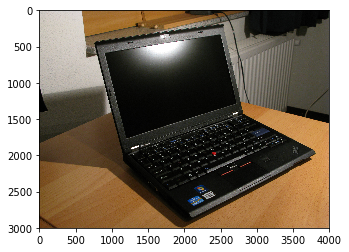

In [3]:
img_laptop_url = "https://www.dropbox.com/s/cbe6dg3e59tm122/ThinkPad_X220.jpg?dl=1"
img_laptop = PIL.Image.open(BytesIO(requests.get(img_laptop_url).content))
imshow(np.asarray(img_laptop))

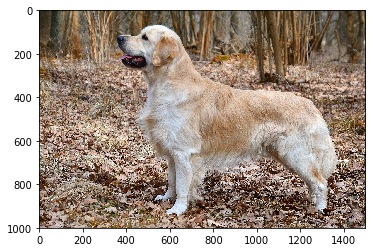

In [4]:
img_golden_url = "https://www.dropbox.com/s/4ulimqtaable3es/Golden_Retriever_Carlos_%2810581910556%29.jpg?dl=1"
img_golden = PIL.Image.open(BytesIO(requests.get(img_golden_url).content))
imshow(np.asarray(img_golden))

In [5]:
# Load previously saved Core ML model of MobileNet v2

mlmodel = coremltools.models.MLModel('mobilenet_v2_1.0_224.mlmodel')

In [6]:
# Get spec from the model

spec = mlmodel.get_spec()
print(spec.description)

input {
  name: "input__0"
  type {
    imageType {
      width: 224
      height: 224
      colorSpace: RGB
    }
  }
}
output {
  name: "MobilenetV2__Predictions__Reshape_1__0"
  type {
    dictionaryType {
      stringKeyType {
      }
    }
  }
}
output {
  name: "classLabel"
  type {
    stringType {
    }
  }
}
predictedFeatureName: "classLabel"
predictedProbabilitiesName: "MobilenetV2__Predictions__Reshape_1__0"



In [7]:
img_golden = img_golden.resize([224,224], PIL.Image.ANTIALIAS)
img_laptop = img_laptop.resize([224,224], PIL.Image.ANTIALIAS)

In [8]:
INPUT_TENSOR = "input__0"
OUTPUT_TENSOR = "MobilenetV2__Predictions__Reshape_1__0"
PREDICTED_FEATURE_NAME = "classLabel"

# Prediction is run on CPU
coreml_output_golden = mlmodel.predict({INPUT_TENSOR: img_golden}, useCPUOnly=True)

#Prediction is run on GPU
coreml_output_laptop = mlmodel.predict({INPUT_TENSOR: img_laptop}, useCPUOnly=False)

predicted_label_for_golden = coreml_output_golden[PREDICTED_FEATURE_NAME]
predicted_label_for_laptop = coreml_output_laptop[PREDICTED_FEATURE_NAME]

print("Prediction for Golden Retriever:",
      predicted_label_for_golden, 
      coreml_output_golden[OUTPUT_TENSOR][predicted_label_for_golden])
print("Prediction for laptop:",
      predicted_label_for_laptop, 
      coreml_output_laptop[OUTPUT_TENSOR][predicted_label_for_laptop])

Prediction for Golden Retriever: golden retriever 0.6118534803390503
Prediction for laptop: notebook 0.5150912404060364


# TensorFlow model inspection

In [9]:
LABELS_FILE = 'ImageNetLabels.txt' 
with open(LABELS_FILE) as f:
    labels = f.read().splitlines() 

In [10]:
# Prepare images for TensorFlow requirements

#Convert to expected type: float
img_laptop_tf = np.array(img_laptop).astype(np.float32) 
# Setup expected input shape: [1,224,224,3]
img_laptop_tf = np.expand_dims(img_laptop_tf, axis = 0) 
# Convert to expected values ranges: [0, 1]
img_laptop_tf = (1.0/255.0) * img_laptop_tf 

print( 'Image shape:', img_laptop_tf.shape)
print( 'First few values: ', img_laptop_tf.flatten()[0:4], 'max value: ', np.amax(img_laptop_tf))

Image shape: (1, 224, 224, 3)
First few values:  [0.8078432  0.78823537 0.7686275  0.7960785 ] max value:  1.0


In [11]:
# Same for golden
img_golden_tf = np.array(img_golden).astype(np.float32) 
img_golden_tf = np.expand_dims(img_golden_tf, axis = 0) 
img_golden_tf = (1.0/255.0) * img_golden_tf 

In [12]:
# Load TensorFlow frozen model

TF_FROZEN_MODEL = "mobilenet_v2_1.0_224_frozen.pb"
with open(TF_FROZEN_MODEL, 'rb') as f:
    serialized_model = f.read()
tf.reset_default_graph()
graph_definition = tf.GraphDef()
graph_definition.ParseFromString(serialized_model)

with tf.Graph().as_default() as g:
    tf.import_graph_def(graph_definition, name='')

In [13]:
# Learn about the model 
!cat mobilenet_v2_1.0_224_info.txt

Model: mobilenet_v2_1.0_224
Input: input
Output: MobilenetV2/Predictions/Reshape_1


In [14]:
TF_INPUT_TENSOR = 'input:0'
TF_OUTPUT_TENSOR = 'MobilenetV2/Predictions/Reshape_1:0'

In [15]:
with tf.Session(graph = g) as sess:
    tf_laptop_out = sess.run(TF_OUTPUT_TENSOR, feed_dict={TF_INPUT_TENSOR: img_laptop_tf})
    tf_golden_out = sess.run(TF_OUTPUT_TENSOR, feed_dict={TF_INPUT_TENSOR: img_golden_tf})
tf_laptop_out = tf_laptop_out.flatten()    
tf_golden_out = tf_golden_out.flatten()    
laptop_idx = np.argmax(tf_laptop_out)
golden_idx = np.argmax(tf_golden_out)

print("Prediction for Golden Retriever:",
      labels[golden_idx], 
      str(tf_golden_out[golden_idx]))
print("Prediction for laptop:",
      labels[laptop_idx], 
      str(tf_laptop_out[laptop_idx]))

Prediction for Golden Retriever: golden retriever 0.61186796
Prediction for laptop: notebook 0.51475537


Predictions from TensorFlow and Core ML are pretty similar. But not the same!
If you look closer, you will notice, that Core ML prediction run on CPU produces results closer to the ones form TensorFlow (it's because this version of TF uses CPU during inference process). The difference is a bit bigger when CoreML is run on GPU.

**Core ML:**  
Prediction for Golden Retriever: golden retriever 0.6118534803390503 <-- CPU  
Prediction for laptop: notebook 0.5150912404060364 <-- GPU

**TensorFlow:**  
Prediction for Golden Retriever: golden retriever 0.61186796  
Prediction for laptop: notebook 0.51475537